# Train custom segmentation model with `IceVision`, `OpenImages`, and `SageMaker`
## Sagemaker Training and Local Inference using TorchServe 

Sources:
- https://github.com/aws/sagemaker-training-toolkit
- https://github.com/aws/sagemaker-inference-toolkit
- https://github.com/giuseppeporcelli/sagemaker-custom-training-containers
- https://github.com/aws-samples/amazon-sagemaker-bert-classify-pytorch
- https://github.com/monocongo/openimages
- https://github.com/jsbroks/imantics
- https://github.com/airctic/icevision

This notebook will show you how to get mask annotations from the [Open Images](https://storage.googleapis.com/openimages/web/index.html) dataset, launch a `Sagemaker` training job, save your model artifacts onto `S3`, and create a `*.mar` file that you can use later to serve your model with `Torchserve`. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Install dependencies

In [2]:
%%capture
!pip install -r ../training_code/requirements.txt

## Configuration

This notebook has been created and tested on a `ml.c5.xlarge` notebook instance.

- The `S3` bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The `IAM role` arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `sagemaker.get_execution_role()` with a the appropriate full `IAM role` arn string(s).

In [3]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [4]:
role = get_execution_role()
region = boto3.Session().region_name
sagemaker_session = sagemaker.session.Session()
bucket = sagemaker_session.default_bucket()

In [5]:
print(f'region: "{region}"')
print(f'role: "{role}"')
print(f'bucket: "{bucket}"')

region: "eu-west-2"
role: "arn:aws:iam::849118573017:role/service-role/AmazonSageMaker-ExecutionRole-20210113T160042"
bucket: "sagemaker-eu-west-2-849118573017"


In [6]:
prefix = 'maskrcnn-torchserve-example'
train_class_label = "Coin" # class label among 600 available
data_dir = './data'

## Download and prepare data

Source:
- https://github.com/monocongo/openimages
- https://storage.googleapis.com/openimages/web/index.html

### Download images and segmentation masks from `OpenImages`
- Source: https://storage.googleapis.com/openimages/web/index.html

> Open Images is a dataset of ~9M images annotated with image-level labels, object bounding boxes, object segmentation masks, visual relationships, and localized narratives:
>
> It contains a total of 16M bounding boxes for 600 object classes on 1.9M images, making it the largest existing dataset with object location annotations. The boxes have been largely manually drawn by professional annotators to ensure accuracy and consistency. The images are very diverse and often contain complex scenes with several objects (8.3 per image on average).
Open Images also offers visual relationship annotations, indicating pairs of objects in particular relations (e.g. "woman playing guitar", "beer on table"), object properties (e.g. "table is wooden"), and human actions (e.g. "woman is jumping"). In total it has 3.3M annotations from 1,466 distinct relationship triplets.
In V5 we added segmentation masks for 2.8M object instances in 350 classes. Segmentation masks mark the outline of objects, which characterizes their spatial extent to a much higher level of detail.
In V6 we added 675k localized narratives: multimodal descriptions of images consisting of synchronized voice, text, and mouse traces over the objects being described. (Note we originally launched localized narratives only on train in V6, but since July 2020 we also have validation and test covered.)
Finally, the dataset is annotated with 59.9M image-level labels spanning 19,957 classes.

In [7]:
from openimages.download import download_segmentation_dataset

In [8]:
download_segmentation_dataset(
    dest_dir=f"{data_dir}/annotations", 
    class_labels=[train_class_label,], 
    annotation_format="pascal", 
    meta_dir=f"{data_dir}/csv")

2021-03-22  21:47:20 INFO Reading bounding box data
GET train-annotations-bbox.csv: 100%|██████████| 1.19G/1.19G [00:35<00:00, 34.1MiB/s]
2021-03-22  21:48:12 INFO NumExpr defaulting to 4 threads.
2021-03-22  21:48:14 INFO Reading segmentation mask data
GET train-annotations-object-segmentation.csv: 100%|██████████| 807M/807M [00:41<00:00, 19.3MiB/s] 
2021-03-22  21:49:07 INFO Downloading 682 train images and accompanying segmentation masks for class 'coin'
GET train-masks-0.zip: 100%|██████████| 386M/386M [00:09<00:00, 41.1MiB/s] 
GET train-masks-1.zip: 100%|██████████| 298M/298M [00:07<00:00, 39.0MiB/s] 
GET train-masks-2.zip: 100%|██████████| 285M/285M [00:08<00:00, 32.9MiB/s] 
GET train-masks-3.zip: 100%|██████████| 282M/282M [00:05<00:00, 53.4MiB/s] 
GET train-masks-4.zip: 100%|██████████| 278M/278M [00:09<00:00, 30.3MiB/s] 
GET train-masks-5.zip: 100%|██████████| 274M/274M [00:10<00:00, 25.5MiB/s] 
GET train-masks-6.zip: 100%|██████████| 277M/277M [00:04<00:00, 57.0MiB/s] 
GET tr

{'coin': {'images_dir': './data/annotations/coin/images',
  'segmentations_dir': './data/annotations/coin/segmentations',
  'annotations_dir': './data/annotations/coin/pascal'}}

### Convert annotations from `PASCAL` to `COCO`

In [9]:
def _create_coco_annotation_json(input_dir:str=None, class_label:str=None, fname:str='coco_annotation.json'):
    """
    Author: Nicolas Metallo
    Generates a COCO annotated json that maps images with segmentation masks
    :param input_dir: directory where OID V5 annotations are saved
    :param class_label: one of the 600 class labels available in OID 
    :param fname: output filename
    """
    from datetime import date
    from pathlib import Path
    from collections import defaultdict
    from PIL import Image
    import numpy as np
    import json
    import imantics
    
    # create list of images/segmentations
    data_dir = Path(f'{input_dir}/{class_label.lower()}')
    images_dir = data_dir / 'images'
    annotations_dir = data_dir / 'pascal'
    segmentations_dir = data_dir / 'segmentations'
    list_of_images = [x for x in images_dir.rglob('*.jpg')]
    list_of_segmentations = [x for x in segmentations_dir.rglob('*.png')]
    
    # sanity check
    if not list_of_images or not list_of_segmentations:
        print('error! no images/segmentations have been found, please check your `input_dir`')
        return
    
    # create coco dict
    coco_segm_dict = defaultdict(list, { str(k):[] for k in list_of_images })
    for img in list_of_images:
        for mask in list_of_segmentations:
            if img.stem in str(mask): coco_segm_dict[str(img)].append(str(mask))

    # create base json
    coco = {
        "info": {
            "description": "Custom COCO Dataset",
            "url": "http://cocodataset.org",
            "version": "1.0",
            "year": 2020,
            "contributor": "Nicolas Metallo",
            "date_created": date.today().strftime("%d/%m/%Y")},
        "images": [],
        "annotations": [],
        "categories": [],
        }

    # merge images with segmentations and create json
    annotations=[]
    images=[]
    segm_id = 0
    print('processing...')
    for id, (img,masks) in enumerate(list(coco_segm_dict.items())):
        image = imantics.Image.from_path(img)
        for x in masks:
            array = np.asarray(Image.open(x).resize(image.size))
            image.add(imantics.Mask(array), category=imantics.Category(class_label))
            image.id = id
            coco_json = image.export(style='coco')
            annotation = coco_json['annotations'][0]
            # sanity check i.e. avoid invalid polygons
            annotation['segmentation'] = [x for x in annotation['segmentation'] if len(x) > 2]
            annotation['id'] = segm_id
            annotations.append(coco_json['annotations'][0])
            segm_id += 1
        images.append(coco_json['images'][0])
        
    # add to json and save to disk
    coco['categories'] = coco_json['categories']
    coco['annotations'] = annotations
    coco['images'] = images
    
    save_path = f'{input_dir}/{fname}'
    with open(save_path, 'w') as f:
        json.dump(coco, f)
    
    print(f"done! file was saved to `{save_path}`")
    return coco, save_path

In [10]:
coco, save_path = _create_coco_annotation_json(
    input_dir=f"{data_dir}/annotations", class_label=train_class_label)

processing...
done! file was saved to `./data/annotations/coco_annotation.json`


### Upload data to `s3`

We are going to use the `sagemaker.Session.upload_data` function to upload our datasets to an `S3` location. The return value inputs identifies the location -- we will use later when we start the training job.

In [11]:
inputs = sagemaker_session.upload_data(
    path=f"{data_dir}/annotations", bucket=bucket, key_prefix=prefix)

In [12]:
print(f"{inputs}")

s3://sagemaker-eu-west-2-849118573017/mask-rcnn-remove-bkg


## Model Training using SageMaker

### Training script

The drive.py script provides all the code we need for training and hosting a SageMaker model (model_fn function to load a model). The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

- `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to. These artifacts are uploaded to S3 for model hosting.
- `SM_NUM_GPUS`: The number of gpus available in the current container.
- `SM_CURRENT_HOST`: The name of the current container on the container network.
- `SM_HOSTS`: `JSON` encoded list containing all the hosts .

Supposing one input channel, `training`, was used in the call to the PyTorch estimator's `fit()` method, the following will be set, following the format `SM_CHANNEL_\[channel_name\]`:

- `SM_CHANNEL_TRAINING`: A string representing the path to the directory containing data in the 'training' channel.

For more information about training environment variables, please visit SageMaker Containers.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance.

Because the `SageMaker` imports the training script, you should put your training code in a main guard (`if __name__=='__main__':`) if you are using the same script to host your model as we do in this example, so that SageMaker does not inadvertently run your training code at the wrong point in execution.

In [196]:
!pygmentize ../training_code/train.py

import sys
import os
import argparse
from PIL import Image
from icevision.all import *

def _train(
    input_dir:str=None, class_label:str=None, coco_fname:str='coco_annotation.json', 
    epochs:int=20, lr:float=5e-4, img_presize:int=512, img_size:int=384, bs:int=16):
    """ Main function that launches model training and saves output in S3 """
    # create list of images/segmentations
    data_dir = Path(f'{input_dir}/{class_label.lower()}')
    images_dir = data_dir / 'images'
    
    # Parse records with random splits
    parser = parsers.COCOMaskParser(annotations_filepath=f'{input_dir}/{coco_fname}', img_dir=images_dir)
    train_records, valid_records = parser.parse()
    class_map = ClassMap([class_label.lower()])

    # Define the transforms and create the Datasets
    presize = img_presize
    size = img_size
    shift_scale_rotate = tfms.A.ShiftScaleRotate(rotate_limit=10)
    crop_fn = partial(tfms.A.RandomSizedCrop, min_max_height=(size // 2, size), p=0.5)
    train_tfms

### Training Configuration

In [17]:
train_instance_type='ml.p3.2xlarge'
# train_instance_type='local'

In [52]:
use_spot = False

train_max_run_secs = 2 * (24 * 60 * 60) # 48 hours
spot_wait_sec =  (5 * 60) # 5 minutes
max_wait_time_secs = train_max_run_secs + spot_wait_sec

if not use_spot:
    max_wait_time_secs = None
    
# During local mode, no spot.., use smaller dataset
if train_instance_type == 'local':
    use_spot = False
    max_wait_time_secs = 0
    wait = True
    # Use smaller dataset to run locally
    inputs = inputs_sample

### Launch Training Job in SageMaker

The `PyTorch` class allows us to run our training function as a training job on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, the training instance type, and hyperparameters. In this case we are going to run our training job on an `ml.p3.2xlarge` instance. But this example can be run on other CPU or GPU instance types as well. The hyperparameters parameter is a dict of values that will be passed to your training script -- you can see how to access these values in the mnist.py script above.

In [108]:
import datetime
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point='train.py',
    source_dir='../training_code',
    role=role,
    framework_version ="1.8.0",
    py_version='py3',
    instance_count=1,
    instance_type=train_instance_type,
    hyperparameters = {"epochs":20,"lr":5e-4,"bs":16,"class-label": train_class_label},
    base_job_name = prefix,
    use_spot_instances = use_spot,
    max_run =  train_max_run_secs,
    max_wait = max_wait_time_secs)

After we've constructed our `PyTorch` object, we can fit it using the data we uploaded to `S3`. `Sagemaker` makes sure our data is available in the local filesystem, so our training script can simply read the data from disk.

In [109]:
estimator.fit(inputs, wait=True)

2021-03-29  13:28:11 INFO Defaulting to the only supported framework/algorithm version: latest.
2021-03-29  13:28:11 INFO Ignoring unnecessary instance type: None.
2021-03-29  13:28:11 INFO Creating training-job with name: mask-rcnn-remove-bkg-2021-03-29-13-28-11-560


2021-03-29 13:28:12 Starting - Starting the training job...
2021-03-29 13:28:36 Starting - Launching requested ML instancesProfilerReport-1617024491: InProgress
......
2021-03-29 13:29:37 Starting - Preparing the instances for training.........
2021-03-29 13:30:57 Downloading - Downloading input data...
2021-03-29 13:31:37 Training - Downloading the training image............
2021-03-29 13:33:38 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-03-29 13:33:37,915 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-03-29 13:33:37,938 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-03-29 13:33:38,572 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-03-29 13:33:38,909 sagemaker-training-toolkit INFO     Installing dependencies from requ

UnexpectedStatusException: Error for Training job mask-rcnn-remove-bkg-2021-03-29-13-28-11-560: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python3.6 train.py --bs 16 --class-label Coin --epochs 20 --lr 0.0005"
  0%|          | 0/1702 [00:00<?, ?it/s] 17%|ââ        | 294/1702 [00:00<00:00, 2930.54it/s] 34%|ââââ      | 582/1702 [00:00<00:00, 2913.79it/s] 55%|ââââââ    | 929/1702 [00:00<00:00, 3059.03it/s] 72%|ââââââââ  | 1226/1702 [00:00<00:00, 3030.43it/s] 90%|âââââââââ | 1534/1702 [00:00<00:00, 3044.78it/s]100%|ââââââââââ| 1702/1702 [00:00<00:00, 3052.22it/s]
[1m[1mINFO    [0m[1m[0m - [1m[34m[1mAutofixing records[0m[1m[34m[0m[1m[0m | [36micevision.parsers.parser[0m:[36mparse[0m:[36m126[0m
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
  0%|          | 0.00/170M [00:00<?, ?B/s]  3%|â         | 5.49M/170M [00:00<00:02, 57.5MB/s]  8%|â         | 13.1M/170M

#### 2.3.1) Savings

Towards the end of the job you should see two lines of output printed:

- Training seconds: X : This is the actual compute-time your training job spent
- Billable seconds: Y : This is the time you will be billed for after Spot discounting is applied.

If you enabled the `use_spot_instances` var then you should see a notable difference between X and Y signifying the cost savings you will get for having chosen Managed Spot Training. This should be reflected in an additional line:

- Managed Spot Training savings: `(1-Y/X)*100 %`

**Example Pricing:** 

- Based on [current pricing](https://aws.amazon.com/sagemaker/pricing/) for the London Region, a `p3.x2large` instance is `$4.486` per hr.
- Based on a total average time of 21 minutes, the training time was around 1100 seconds. Because we are using spot, the billable seconds are actually 330 (70% savings) and so the total cost is: `(330/(60*60)) * ($4.486) = $0.412`

## TorchServe – PyTorch Model Serving

Source: 
- https://github.com/pytorch/serve

TorchServe is a flexible and easy to use tool for serving PyTorch models. For full documentation, see **[Model Server for PyTorch Documentation](docs/README.md).**

## TorchServe Architecture
![Architecture Diagram](https://user-images.githubusercontent.com/880376/83180095-c44cc600-a0d7-11ea-97c1-23abb4cdbe4d.jpg)

### Terminology:
* **Frontend**: The request/response handling component of TorchServe. This portion of the serving component handles both request/response coming from clients and manages the lifecycles of the models.
* **Model Workers**: These workers are responsible for running the actual inference on the models. These are actual running instances of the models.
* **Model**: Models could be a `script_module` (JIT saved models) or `eager_mode_models`. These models can provide custom pre- and post-processing of data along with any other model artifacts such as state_dicts. Models can be loaded from cloud storage or from local hosts.
* **Plugins**: These are custom endpoints or authz/authn or batching algorithms that can be dropped into TorchServe at startup time.
* **Model Store**: This is a directory in which all the loadable models exist.

### Download Trained Model

In [ ]:
model_uri = estimator.model_data
print(model_uri)

In [27]:
s3 = boto3.client('s3')
s3.download_file(bucket, model_uri.split(bucket)[1:][0][1:], '../model_store/model.tar.gz')
print('done!')

done!


### Extract Model Artifacts

In [28]:
!tar -xvf ../model_store/model.tar.gz --directory ../model_store

classes.txt
model.pth


### Install Torchserve

- https://github.com/pytorch/serve
- https://github.com/pytorch/serve/blob/master/model-archiver/

In [30]:
%%capture

!pip install torchserve torch-model-archiver

### Package your PyTorch model as `*.mar` file

With the model artifacts available locally, you can use the torch-model-archiver CLI to generate a `.mar` file that can be used to serve an inference API with TorchServe.

#### Creating mar file for torchscript mode model

Following are the steps to create a torch-model-archive `(.mar)` to execute an eager mode torch model in TorchServe :

Pre-requisites to create a torch model archive `(.mar)` :

- `serialized-file (.pt)` : This file represents the state_dict in case of eager mode model or an executable ScriptModule in case of TorchScript.
- `index_to_name.json` : This file contains the mapping of predicted index to class. The default TorchServe handles returns the predicted index and probability. This file can be passed to model archiver using --extra-files parameter.
- `version` : Model's version.
- `handler` : TorchServe default handler's name or path to custom inference handler(.py)

In [46]:
!torch-model-archiver --model-name {prefix} \
    --version 1.0 --serialized-file ../model_store/model.pt \
    --export-path ../model_store --handler ../deployment_code/handler.py -f

WARNING - Overwriting ../model_store/mask-rcnn-remove-bkg.mar ...


#### Creating `mar` file for eager mode model

Following are the steps to create a torch-model-archive `(.mar)` to execute an eager mode torch model in TorchServe :

Pre-requisites to create a torch model archive `(.mar)` :

- `serialized-file (.pt)` : This file represents the state_dict in case of eager mode model.
- `model-file (.py)` : This file contains model class extended from torch nn.modules representing the model architecture. This parameter is mandatory for eager mode models. This file must contain only one class definition extended from torch.nn.modules
- `index_to_name.json` : This file contains the mapping of predicted index to class. The default TorchServe handles returns the predicted index and probability. This file can be passed to model archiver using --extra-files parameter.
- `version` : Model's version.
- `handler` : TorchServe default handler's name or path to custom inference handler(.py)

In [173]:
!torch-model-archiver --model-name {prefix} \
    --version 1.0 --model-file ../deployment_code/torchserve_byoc_with_amazon_sagemaker/model.py \
    --serialized-file ../model_store/model.pth \
    --export-path ../model_store --handler ../deployment_code/torchserve_byoc_with_amazon_sagemaker/handler.py -f

WARNING - Overwriting ../model_store/mask-rcnn-remove-bkg.mar ...


### Start TorchServe and Serve model 

Run `torchserve --start --ncs --model-store ../model_store --models {prefix}.mar` in your terminal

### Use REST APIs to get model prediction

In [176]:
import requests
import io
import time
import base64

from PIL import Image
from urllib.request import urlopen

In [184]:
def get_image_bytes(url_or_path:str):
    try:
        response = requests.get(url_or_path)
        data = urlopen(url_or_path)
    except Exception:
        data = open(url_or_path,'rb')
    return data.read()

In [185]:
path_to_image = 'https://df2sm3urulav.cloudfront.net/tenants/ca/uploads/images/0-4999/1601/5d82a21c1abf4.jpg'
# path_to_image = 'test_images/FindID_161098.jpg'

In [193]:
now = time.time()
url = f'http://127.0.0.1:8080/predictions/{prefix}/'
data = get_image_bytes(path_to_image)
headers = {'content-type': 'image/jpg'}

# r = requests.post(url, json=payload, headers=headers)
r = requests.put(url, data=data, headers=headers)
response = r.json()
print(f'Response: {r} / Proc. Time: {(time.time()-now):.2f} s')

Response: <Response [200]> / Proc. Time: 0.89 s


### Visualise prediction

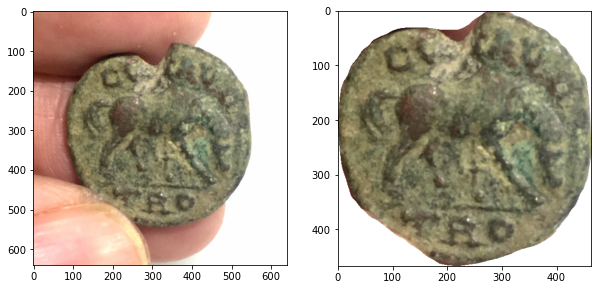

In [194]:
import matplotlib.pyplot as plt

target_image = Image.open(io.BytesIO(data))
predicted_image = predicted_image = Image.open(io.BytesIO(base64.b64decode(response['base64_prediction'])))

f = plt.figure(figsize=(10,10))
f.add_subplot(1,2,1)
plt.imshow(target_image)
f.add_subplot(1,2, 2)
plt.imshow(predicted_image)
plt.show(block=True)

### Stop the running TorchServe

In [195]:
!torchserve --stop

TorchServe has stopped.
